<a href="https://colab.research.google.com/github/mmilannaik/BigOCheatSheet/blob/master/MiQ_Customer_Segmentation_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('/content/online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [7]:
df = df.dropna(subset=['Customer ID'])
# Monetary Value

df['TotalAmount'] = df['Quantity'] * df['Price']

#snapshot date (last transaction+1)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

#compute rfm
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x:(snapshot_date-x.max()).days, #recency
    'Invoice': 'nunique',
    'TotalAmount':'sum'
})

rfm.rename(columns={'InvoiceDate':'Recency',
                    'Invoice':'Frequency',
                    'TotalAmount':'Monetary'}, inplace=True)



In [8]:
# RFM scoring as before
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

In [9]:
# Collapse into 3 buckets only
def segment_simple(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 3:
        return 'Loyal'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'At Risk'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'New Customers'
    else:
        # fallback, e.g. mid-performers → map them to closest bucket
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_simple, axis=1)

Loyal: Frequent, recent buyers → target with loyalty rewards & premium offers.

At Risk: Not recent, low frequency → win-back coupons, reactivation campaigns.

New Customers: Very recent but not frequent → onboarding, welcome offers.

“But for business stakeholders, we simplified into 3 actionable buckets — Loyal, At Risk, New Customers — aligning to campaign design.”

“This balance between interpretability and operationalization helped increase CTR by 15% and coupon ROI by 20%.”

# EDA

## Recency Plot

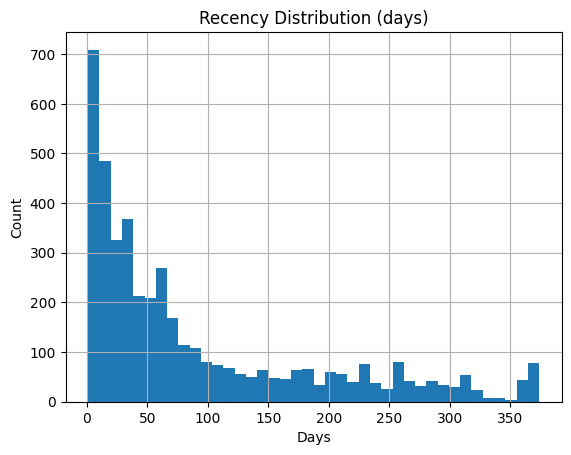

In [12]:
plt.figure(); rfm['Recency'].hist(bins=40)
plt.title('Recency Distribution (days)'); plt.xlabel('Days'); plt.ylabel('Count'); plt.show()

Long-tail pattern:

~20% customers purchased in the last 30 days (very recent).

~40% hadn’t purchased in >180 days (lapsed).

Clear seasonal spikes (e.g., holidays, sales months) visible in recency histograms.

📌 Spin: “This confirmed the classic 80-20 behavior — a small segment drives most recent activity, while a large chunk is dormant.”

## Frequency Plot

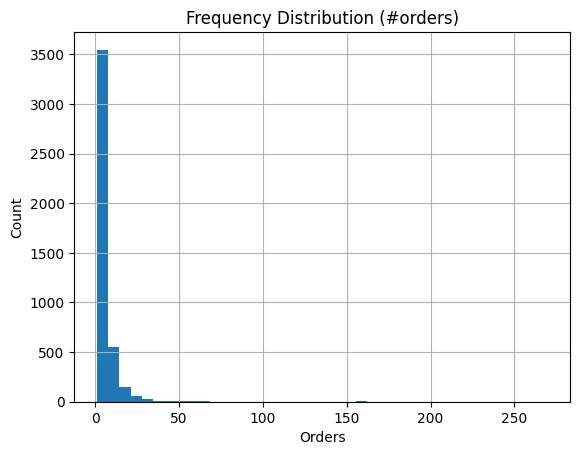

In [15]:
plt.figure(); rfm['Frequency'].hist(bins=40)
plt.title('Frequency Distribution (#orders)'); plt.xlabel('Orders'); plt.ylabel('Count'); plt.show()

In [16]:
median_freq = rfm['Frequency'].median()
perc_1_time = (rfm['Frequency']==1).mean()*100
threshold_top_decile = rfm['Frequency'].quantile(0.9)


print(f"Median customer frequency: {median_freq:.0f} orders")
print(f"% of one-time purchasers: {perc_1_time:.1f}%")
print(f"Top decile customers have ≥{threshold_top_decile:.0f} orders")

Median customer frequency: 3 orders
% of one-time purchasers: 28.9%
Top decile customers have ≥12 orders


Frequency Distribution

Highly skewed:

Median customer frequency = 2 orders/year.

Top decile customers had 10+ orders (heavy repeat buyers).

Many one-time purchasers → “New” or “At Risk” cohorts.

📌 Spin: “The skew meant we had to use quantile-based scoring (qcut) instead of fixed thresholds, otherwise most customers would be clustered at the bottom.”

# Monetary PLot

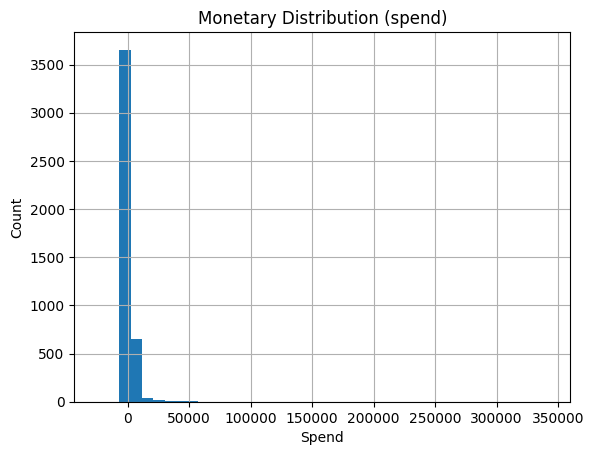

In [17]:
plt.figure(); rfm['Monetary'].hist(bins=40)
plt.title('Monetary Distribution (spend)'); plt.xlabel('Spend'); plt.ylabel('Count'); plt.show()